# Lời giới thiệu đề tài: dự đoán bệnh nhân có khả năng bị mắc viêm phổi

- Nguồn dữ liệu mà chúng tôi thu thập được sẽ bao gồm có 3 hình ảnh kết quả chính về người bình thường, người bị viêm phổi do vi khuẩn, người bị viêm phổi do virus gây nên.

---



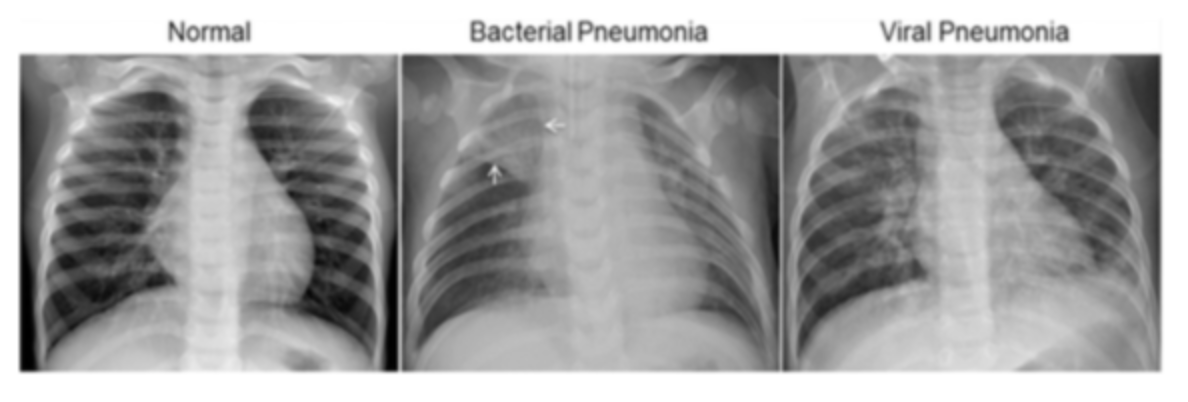

	•	Ảnh X-quang ngực bình thường (bên trái) cho thấy phổi trong, không có vùng mờ bất thường.
	•	Viêm phổi do vi khuẩn (giữa) thường biểu hiện dưới dạng đông đặc khu trú ở một thùy, trong trường hợp này là thùy trên bên phải (mũi tên trắng).
	•	Viêm phổi do virus (bên phải) biểu hiện với kiểu “kẽ” lan tỏa hơn ở cả hai phổi.

In [1]:
# grad-cam

## Nội dung chính


- Bộ dữ liệu được tổ chức thành 3 thư mục (train, test, val) và mỗi thư mục chứa các thư mục con cho từng loại ảnh (Pneumonia/Normal). Tổng cộng có 5.863 ảnh X-quang (định dạng JPEG) và 2 nhãn phân loại (Pneumonia/Normal).

- Các ảnh X-quang ngực (tư thế trước-sau) được lựa chọn từ dữ liệu hồi cứu của các bệnh nhân nhi từ 1 đến 5 tuổi tại Trung tâm Phụ nữ và Trẻ em Quảng Châu. Tất cả ảnh X-quang đều được chụp như một phần trong quá trình chăm sóc y tế thường quy.

- Trong quá trình phân tích ảnh X-quang ngực, tất cả các phim X-quang đều được sàng lọc kiểm tra chất lượng ban đầu để loại bỏ các ảnh chất lượng kém hoặc không đọc được. Việc chẩn đoán cho các ảnh sau đó được phân loại bởi hai bác sĩ chuyên khoa trước khi được đưa vào hệ thống AI để huấn luyện. Để tránh sai sót trong quá trình đánh giá, bộ dữ liệu kiểm định (evaluation set) cũng được kiểm tra lại bởi một chuyên gia thứ ba.

### Thiết lập môi trường cho mô hình học máy 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
train_dir = "/Users/macbook/Downloads/chest_xray/train"
val_dir = "/Users/macbook/Downloads/chest_xray/val"
test_dir = "/Users/macbook/Downloads/chest_xray/test"



### Tiền xử lý dữ liệu 

In [4]:

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_generator = val_gen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

test_generator = test_gen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=1, class_mode='categorical', shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


thư mục được chia sẵn thành 3 với tập train,val,test...
- train	~80%
- Val ~0.25%
- Test ~20%



- đối với tập train thì tụi em sử dụng tiền xử lý normalize hoạt động thay đổi định dạng sang BGR. Mỗi kênh mày sẽ giá trịnh trung của tập imagenet mean = [103.939, 116.779, 123.68] với định như là (B G R)
- Và với tập train thì để tăng cường dữ liệu thì tụi em có phương pháp xoay ngang và lật ngang để mô hình không bị phụ thuộc nhiều quá vào chỗ bị viêm 
-> mục đích của việc tiền xử lý mà tụi em áp dụng vào giúp mô hình học máy có cái nhìn tổng quát hơn và tránh bị overfitting

- đối với tập dữ liệu test, validation thì vẫn giữ nguyên để làm kết quả đối chiếu với bộ dữ liệu train 

- chuẩn hóá và đồng bộ thì tụi em có thống nhất chiều cao và chiều rộng của ảnh 224 x 224 với số lượng ảnh được chưa vào huấn luyện là 32 (batch size)

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

- với tập trọng số imagenet sử dụng lại các trọng số đã được huấn luyện sẵn của ResNet50 trên tập dữ liệu ImageNet.


In [6]:
for layer in base_model.layers[-30:]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

- để tối ưu hóa cho mô hình thì tụi em chọn đóng băng 30 lớp cuối với mục đích giữ nguyên “kiến thức gốc” mà mô hình đã học từ ImageNet,

- với optimizer Adam là thuật toán tối ưu nó tự động điều chỉnh tốc độ học cho từng tham số nhưng trong dạng bài dự đoán mô hình viêm phổi thì learning_rate=1e-5 (0.00001) là tốc độ học rất nhỏ để mô hình thích nghi dần với dữ liệu phổi.
- em sử dụng hàm mất mát categorical crossentropy và đo độ chính xác bằng metric accuracy

In [7]:
model.fit(train_generator, validation_data=val_generator, epochs=3 )
print("damn ")


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 5300s 33s/step - accuracy: 0.7770 - loss: 0.4608 - val_accuracy: 0.7500 - val_loss: 0.4724
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 718s 4s/step - accuracy: 0.9043 - loss: 0.2476 - val_accuracy: 0.8125 - val_loss: 0.4537
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 1204s 7s/step - accuracy: 0.9170 - loss: 0.2124 - val_accuracy: 0.7500 - val_loss: 0.3895
damn 


In [8]:
for layer in model.layers:
    print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [9]:

model = load_model("/Users/macbook/Downloads/resnet_pneumonia_model_3.h5")

print("Mô hình đã tải thành công!")
model.summary()

Mô hình đã tải thành công!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,812 (90.00 MB)

 Trainable params: 9,088,514 (34.67 MB)

 Non-trainable params: 14,503,296 (55.33 MB)

 Optimizer params: 2 (12.00 B)

In [10]:


def display_gradcam(img_path, model, layer_name='conv5_block3_out', target_class=1, class_names=['Normal', 'Pneumonia']):
    """
    Display Grad-CAM for pneumonia (or specified class).
    """
    # Step 1: Load and preprocess image
    img_pil = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img_pil)  # (224, 224, 3)
    img_preprocessed = np.expand_dims(img_array.copy(), axis=0)
    img_preprocessed = preprocess_input(img_preprocessed)

    # Step 2: Get predictions
    preds = model.predict(img_preprocessed)
    if len(preds.shape) != 2 or preds.shape[1] != 2:
        raise ValueError(f" Model output shape {preds.shape} invalid. Expected (1, 2).")
    
    preds = preds[0]
    predicted_class = np.argmax(preds)
    pneumonia_confidence = preds[target_class]

    print(f" Model Prediction: {class_names[predicted_class]} (Confidence: {preds[predicted_class]:.2%})")
    print(f" Pneumonia (Class {target_class}) Confidence: {pneumonia_confidence:.2%}")
    if pneumonia_confidence < 1e-5:
        print(" Warning: Very low pneumonia confidence—heatmap may be weak.")

    # Step 3: Get conv layer
    try:
        conv_layer = model.get_layer(layer_name)
    except ValueError:
        raise ValueError(f" Layer '{layer_name}' not found. Available conv layers: {[l.name for l in model.layers if 'conv' in l.name]}")

    grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

    # Step 4: Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_preprocessed)
        print(f"DEBUG: conv_outputs shape: {conv_outputs.shape}")
        print(f"DEBUG: predictions shape: {predictions.shape}")
        loss = predictions[:, target_class]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check model weights or layer compatibility.")
    
    print(f"DEBUG: grads shape: {grads.shape}")

    conv_outputs = conv_outputs[0]
    grads = grads[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    print(f"DEBUG: pooled_grads shape: {pooled_grads.shape}")

    # Step 6: Compute heatmap
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads[tf.newaxis, tf.newaxis, :], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()
    print(f"DEBUG: heatmap shape (before resize): {heatmap.shape}")

    # Step 7: Resize & colorize (đồng bộ màu RGB)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)  # 🔹 Quan trọng: đồng bộ màu với Matplotlib

    # Step 8: Overlay (màu trùng hoàn toàn)
    overlay = cv2.addWeighted(np.uint8(img_array), 0.6, heatmap_colored, 0.4, 0)
    overlay = np.clip(overlay, 0, 255).astype('uint8')

    # Step 9: Visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Original Image\n{os.path.basename(img_path)}")
    plt.imshow(img_array.astype('uint8'))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Grad-CAM Heatmap\nfor {class_names[target_class]}")
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Overlay\n({class_names[target_class]}: {pneumonia_confidence:.2%})")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
def display_random_gradcam(sample_images, model, num_images=3, layer_name='conv5_block3_out', target_class=1, class_names=['Normal', 'Pneumonia']):
    if not sample_images:
        raise ValueError(" sample_images list is empty.")
    selected_images = random.sample(sample_images, min(num_images, len(sample_images)))
    print(f" Randomly selected {len(selected_images)} images: {[os.path.basename(p) for p in selected_images]}")
    for img_path in selected_images:
        try:
            display_gradcam(img_path, model, layer_name, target_class, class_names)
        except Exception as e:
            print(f" Error processing {os.path.basename(img_path)}: {str(e)}")

Cụ thể, sau khi mô hình dự đoán lớp ‘viêm phổi’, em tính mức độ ảnh hưởng của từng bản đồ đặc trưng trong lớp convolution cuối cùng đối với kết quả đó.
Những bản đồ quan trọng được nhân trọng số lớn hơn và cộng lại để tạo bản đồ nhiệt.
Cuối cùng, bản đồ nhiệt được phóng to và phủ lên ảnh gốc — vùng nào màu đỏ là nơi mô hình tập trung để nhận diện viêm phổi.
Nhờ vậy, Grad-CAM giúp em kiểm tra được mô hình có thật sự “nhìn đúng chỗ” hay không.”


 Randomly selected 3 images: ['person91_bacteria_448.jpeg', 'person146_bacteria_700.jpeg', 'NORMAL2-IM-0219-0001.jpeg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
 Model Prediction: Normal (Confidence: 94.02%)
 Pneumonia (Class 1) Confidence: 5.98%


/opt/homebrew/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


DEBUG: conv_outputs shape: (1, 7, 7, 2048)
DEBUG: predictions shape: (1, 2)
DEBUG: grads shape: (1, 7, 7, 2048)
DEBUG: pooled_grads shape: (2048,)
DEBUG: heatmap shape (before resize): (7, 7)


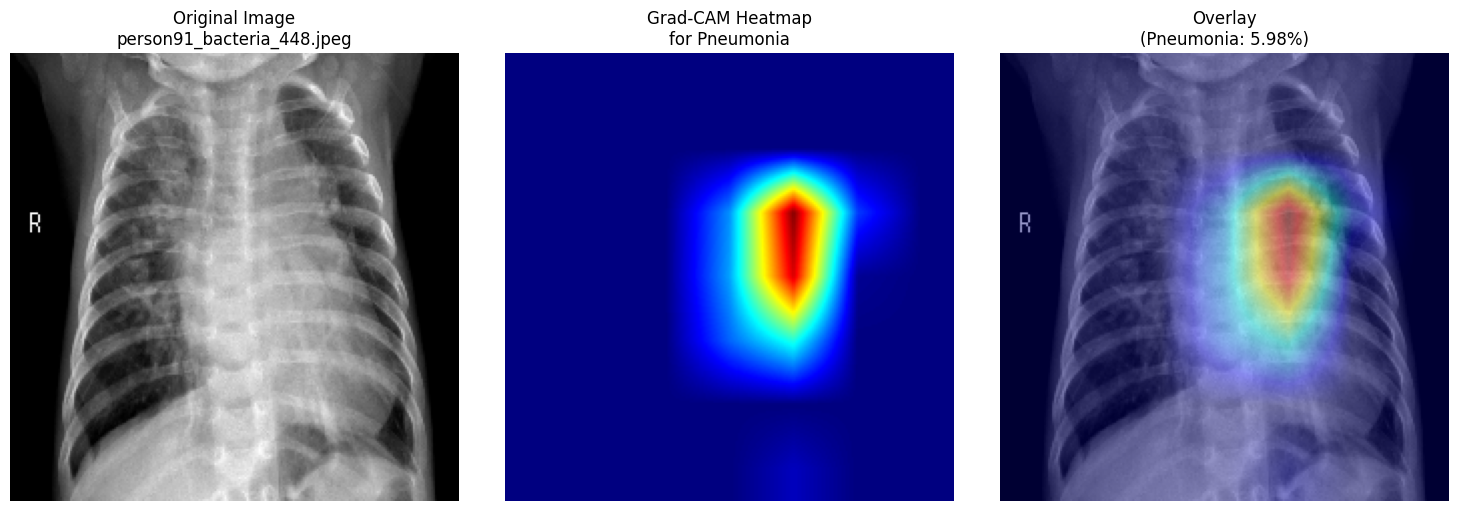

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
 Model Prediction: Pneumonia (Confidence: 64.24%)
 Pneumonia (Class 1) Confidence: 64.24%
DEBUG: conv_outputs shape: (1, 7, 7, 2048)
DEBUG: predictions shape: (1, 2)
DEBUG: grads shape: (1, 7, 7, 2048)
DEBUG: pooled_grads shape: (2048,)
DEBUG: heatmap shape (before resize): (7, 7)


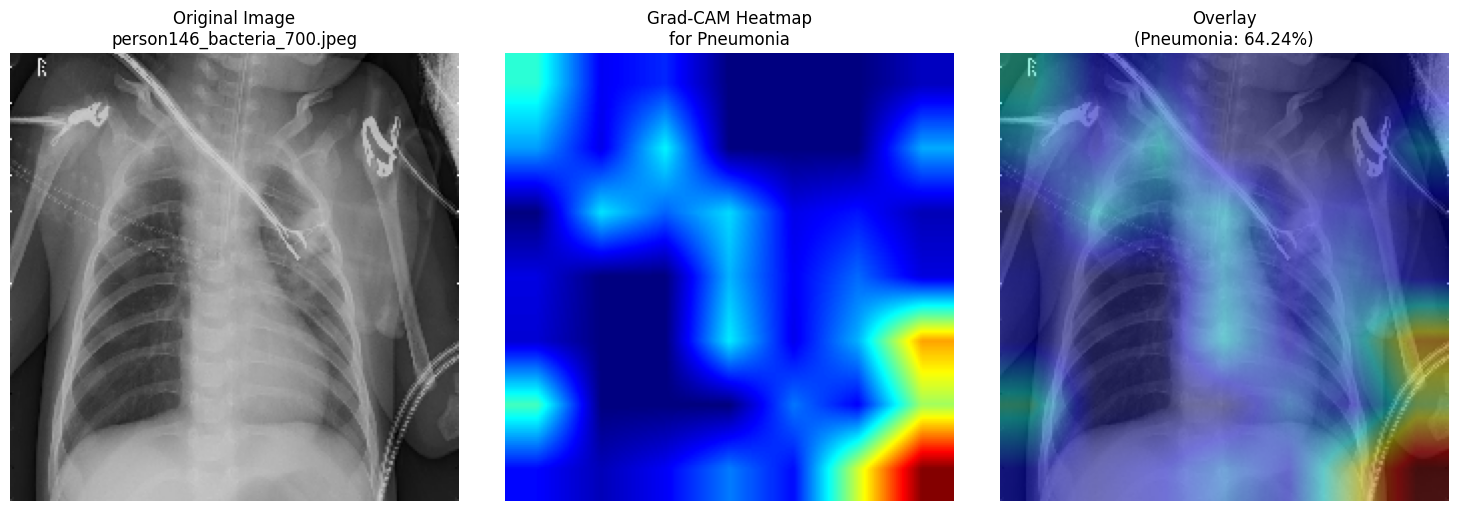

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
 Model Prediction: Pneumonia (Confidence: 97.51%)
 Pneumonia (Class 1) Confidence: 97.51%
DEBUG: conv_outputs shape: (1, 7, 7, 2048)
DEBUG: predictions shape: (1, 2)
DEBUG: grads shape: (1, 7, 7, 2048)
DEBUG: pooled_grads shape: (2048,)
DEBUG: heatmap shape (before resize): (7, 7)


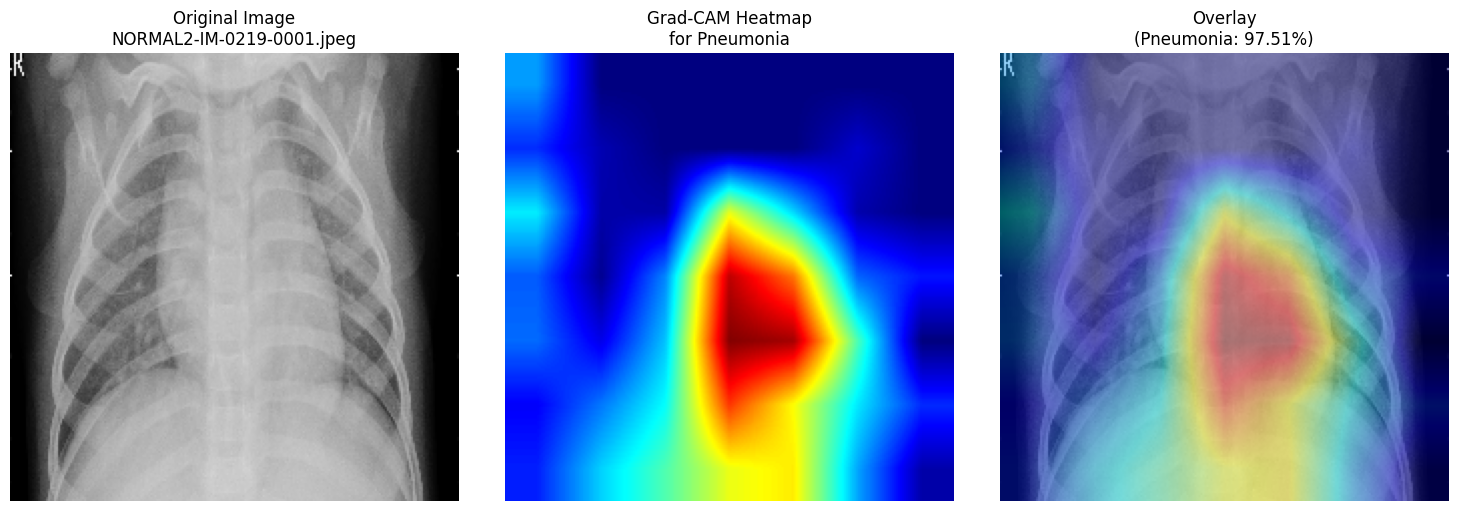

In [12]:
import cv2, os, random
sample_images = random.sample(list(test_generator.filepaths), 5)
display_random_gradcam(sample_images, model, num_images=3, layer_name='conv5_block3_out', target_class=1)

In [13]:
 # Lưu toàn bộ mô hình (kiến trúc + trọng số + optimizer)
model.save(",")

print("✅ Mô hình đã được lưu thành công: resnet_pneumonia_model.h5")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=,.

In [ ]:
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)   # lấy chỉ số lớp dự đoán
y_true = test_generator.classes              # lấy nhãn thật
class_labels = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']
print(" Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
cm = confusion_matrix(y_true, y_pred_classes)
print(" Confusion Matrix:")
print(cm)

624/624 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step
 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.69      0.95      0.80       234
   PNEUMONIA       0.96      0.75      0.84       390

    accuracy                           0.82       624
   macro avg       0.83      0.85      0.82       624
weighted avg       0.86      0.82      0.82       624

 Confusion Matrix:
[[222  12]
 [ 99 291]]
